### LOADING LIBRARIES

In [ ]:
import nltk
import pandas as pd
import numpy as np
import re 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import LancasterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### LOADING DATASET

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
link='/content/drive/MyDrive/IMDB Dataset.csv'

In [ ]:
#id='1cylRRMnYHQaEiUl1OTPKsXvpXCZPpb5d'

In [ ]:
#downloaded = drive.CreateFile({'id':id}) 
#downloaded.GetContentFile('IMDB Dataset.csv')  
df = pd.read_csv(link)

In [ ]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### DATA PREPROCESSING

In [ ]:
def datapreprocessing(data,length):
  stop_words = set(stopwords.words('english'))
  lemmatizer = nltk.stem.WordNetLemmatizer()
  lancaster=LancasterStemmer()
  processed_review = []
  single_review = ""
  reviews = df.review
  for review in range(0,length):
      single_review = data[review]
      #removing html tags:
      single_review = re.sub('<.*?>',' ',single_review)
      #removing special characters (punctuation) '@,!' e.t.c.
      single_review = re.sub('\W',' ',single_review)
      #removing single characters
      single_review = re.sub('\s+[a-zA-Z]\s+',' ', single_review)
      #substituting multiple spaces with single space
      single_review = re.sub('\s+',' ', single_review)
      #removing stop words
      #single_review=single_review.lower()
      #word_tokens = []
      word_tokens = word_tokenize(single_review)
      #lemmatization
      #print(stop_words)
      #print(word_tokens)
      lemmatized_sentence = " ".join(lemmatizer.lemmatize(token) for token in word_tokens if token not in stop_words)
      lemmatized_sentence=lemmatized_sentence.split(" ")
      #print(lemmatized_sentence)
      #filtered_sentence = []
      #filtered_sentence.append([w for w in lemmatized_sentence if w not in stop_words])
      filtered_sentence2 = " ".join([lancaster.stem(w) for w in lemmatized_sentence if w not in stop_words])
      #print(filtered_sentence2)
      
      #compile all the sentences to make a complete dictionary of processed reviews
      processed_review.append(filtered_sentence2)

  return processed_review
    

### TF-IDF

In [ ]:
#multinomial naive bayes
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize_train(data):
  tfidf=TfidfVectorizer(min_df=2,max_df=0.5,ngram_range=(1,2))
  text_count_matrix=tfidf.fit_transform(data)
  return text_count_matrix, tfidf

In [ ]:
def vectorize_test(tfidf,test_data):
  test_matrix=tfidf.transform(test_data)
  return test_matrix

### Splitting The Data into Train and Test(70:30)

In [ ]:
reviews=np.array(df.review)

In [ ]:
processed_review=datapreprocessing(reviews,reviews.shape[0])
#vector_matrix=vectorize(processed_review)

In [ ]:
#summarization
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(processed_review, df.sentiment, test_size=0.30, random_state=2)
train_vector,tfidf=vectorize_train(x_train)
test_vector=vectorize_test(tfidf,x_test)
y_train = (y_train.replace({'positive': 1, 'negative': 0})).values
y_test = (y_test.replace({'positive': 1, 'negative': 0})).values


In [ ]:
print(train_vector.shape)
print(test_vector.shape)

(35000, 513677)
(15000, 513677)


### MultiNomial Naive Bayes

**K fold**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB 
from sklearn import metrics
k_fold=KFold(n_splits=10,shuffle=True)
scores_list=[]
models_list=[]
x=train_vector
y=y_train
max_found=False
max_accuracy_score=None
model_highest=None
for i in range(10):
  result=next(k_fold.split(x),None)
  x_train1=x[result[0]]
  #print(x_train.shape)
  x_test1=x[result[1]]
  #print(x_test.shape)
  #print(y.shape)
  #print(max(result[0]))
  y_train1=y[result[0]]

  y_test1=y[result[1]]
  MNB = MultinomialNB()
  MNB.fit(x_train1, y_train1)
  predict=MNB.predict(x_test1)
  accuracy_score = metrics.accuracy_score(predict, y_test1)
  if(max_found==False or accuracy_score>max_accuracy_score):
    min_found=True
    min_accuracy_score=accuracy_score
    model_highest=MNB

In [ ]:
from sklearn import metrics
predict=model_highest.predict(test_vector)
accuracy_score = metrics.accuracy_score(predict, y_test)
print(accuracy_score)

0.8862


## MOVIE REVIEW SUMMARIZATION

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from scipy.spatial.distance import cosine
from itertools import chain

### SPLITTING TEST DATA INTO POSITIVE REVIEWS AND NEGATIVE REVIEWS

In [ ]:
new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(df.review, df.sentiment, test_size=0.30, random_state=2)
#divided_review=np.split(summary_test, np.where(np.diff(predicted_value[:,]))[0]+1)
divided_review = [new_x_test[predict[:,]==k] for k in np.unique(predict[:,])]

In [ ]:
negative_reviews=list(divided_review[0])[:100]
positive_reviews=list(divided_review[1])[:100]

### DATA PREPROCESSING

In [ ]:
def summary_datapreprocessing(data,length):
  stop_words = set(stopwords.words('english'))
  lemmatizer = nltk.stem.WordNetLemmatizer()
  processed_review = []
  single_review = ""
  reviews = df.review
  for review in range(0,length):
      single_review = data[review]
      #removing html tags:
      single_review = re.sub('<.*?>',' ',single_review)
      #substituting multiple spaces with single space
      single_review = re.sub('\s+',' ', single_review)
      #lower case
      single_review=single_review.lower()
      sentence_token=nltk.sent_tokenize(single_review)
      temp=[]
      for sentence in sentence_token:
        if(len(sentence)>30):
          temp.append(sentence)
      processed_review.append(temp)
   
  
  return processed_review

In [ ]:
processed_positive_reviews=summary_datapreprocessing(positive_reviews,len(positive_reviews))
processed_negative_reviews=summary_datapreprocessing(negative_reviews,len(negative_reviews))

## FINDING SUMMARY

In [ ]:
#flattening the 2d lis-t to single list
from itertools import chain
processed_positive_reviews = list(chain.from_iterable(processed_positive_reviews))
processed_negative_reviews = list(chain.from_iterable(processed_negative_reviews))

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)

In [ ]:
sentence_embeddings = model(processed_positive_reviews)
print(sentence_embeddings.shape)

(1006, 512)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def similarity(sentence_embeddings):
  c_sim=cosine_similarity(sentence_embeddings,sentence_embeddings)
  return c_sim

In [ ]:
positive_similarity=similarity(sentence_embeddings)

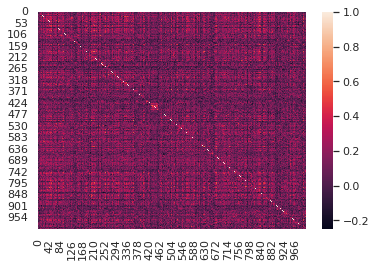

In [ ]:
import seaborn as sns; 
sns.set_theme()
sns.heatmap(positive_similarity)

In [ ]:
temp=np.logical_and(positive_similarity>=0 , positive_similarity<=0.5)
positive_similarity=positive_similarity*temp

In [ ]:
def WGRA(graph):
  rank=np.ones(len(graph))
  new_rank=np.zeros(len(graph))
  d=0.85
  while True:
    for i in range(len(graph)):
      in_nodes=np.where(graph[i]!=0)[0]
      new_rank[i]=0
      for node in in_nodes:
        numerator=rank[node]*graph[i,node]
        denominator=np.sum(graph[node])
        new_rank[i]+=numerator/denominator
      new_rank[i]=1-d+d*new_rank[i]
    temp=np.where(rank-new_rank<0.0001)[0]
    if(len(temp)==len(graph)):
      return new_rank
    else:
      rank=new_rank.copy()

In [ ]:
def final_summary(similarity_matrix,reviews):
  ranks=WGRA(similarity_matrix)
  sorted_reviews=sorted(zip(ranks,reviews),key=lambda x:x[0],reverse=True)
  #print(sorted_reviews[:20])
  final_reviews=[]
  for review in sorted_reviews[:20]:
    final_reviews.append(review[1])
  #final_reviews=sorted_reviews[:20][1]
  #indices=np.argpartition(ranks,-20)[-20:]
  return final_reviews


In [ ]:
from prettytable import PrettyTable
def print_summary(summary):
  for i,review_sentence in enumerate(summary):
    print(i+1,review_sentence)

In [ ]:
positive_final_review=final_summary(positive_similarity,processed_positive_reviews)
print_summary(positive_final_review)

1 even though the film is based on a very romantisised level and not reality, i loved it a lot more than the usual biographys or costume drama's.
2 this movie lacks the gravitas and scale to make it a great film, but it's a fine cheer-up on a rainy afternoon.
3 this film may not have the wit of the thin man series, but undeniably makes up for it in charm.
4 i think a lot of the reason i liked the film so much is that the usual silly dietrich persona as the "über-vamp" isn't present and her role required her to actually act.
5 the atmospherics and the romantic byplay are by far the best part of the movie, as viewers are likely to find the resolution a bit of a letdown -- there's just not that much to it (except a little frisson at the tail end that anticipates brian de palma's filmic codas).
6 this film has a pretty interesting plot, well, a bit far-fetched perhaps, but very melodramatic (with tons of melodramatic music to make sure you get it) - all *greatly* enhanced by the strong, em

In [ ]:
sentence_embeddings_1 = model(processed_negative_reviews)
print(sentence_embeddings_1.shape)

(1083, 512)


In [ ]:
negative_similarity=similarity(sentence_embeddings_1)

In [ ]:
temp=np.logical_and(negative_similarity>=0 , negative_similarity<=0.5)
negative_similarity=negative_similarity*temp

In [ ]:
final_negative_review=final_summary(negative_similarity,processed_negative_reviews)
print_summary(final_negative_review)

1 well let me tell you something, the movie is not even scary in the least bit.
2 if the most important part of the movie isn't even going to happen, at least make it enjoyable to watch and captivating.
3 this was one of the worst films i can remember seeing.
4 i'm not saying there should be fighting and crap blowing up but it would liven up this more than bland film.
5 easily one of the worst films ever made.
6 i wasn't really disappointed with that matter, but this movie is a matter indeed for me, poor plot, useless storyline, naively created and i don't know what to say anymore.
7 the thing that really got me about this film was the stupid purile racism that was evident throughout.
8 this scene was enjoyable but hardly made up for anything else that made this film dog spittle.
9 jay chou's acting isn't exactly the most moving thing i've ever seen, but i certainly enjoyed the movie.
10 sadly, even with a proper leading man this movie doesn't stand a chance for it is fatally burdened 

### LEX SUMMARY

In [ ]:
!pip install sumy
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
positive_reviews=" ".join(processed_positive_reviews)
parser = PlaintextParser.from_string(positive_reviews,Tokenizer("english"))
summarizer = LexRankSummarizer()
summary = summarizer(parser.document, 20)
lex_summary=[]
for sentence in summary:
 lex_summary.append(str(sentence))
lex_summary

     |████████████████████████████████| 94 kB 2.0 MB/s 
     |████████████████████████████████| 10.1 MB 35.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21712 sha256=f2550506459e6aa736a284ddbc955b4f79bc5f6a63084d238fffb9d5f7a25b0c
  Stored in directory: /root/.cache/pip/wheels/d4/bf/51/81d27ad638e1a6dca4f362ecc33d1e2c764b8ea7ec751b8fc1
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=da87c21a0e24e5d2db1499f71625c2c3acdcd954a87c7f41ed0af74154db1f5d
  Stored in directory: /root/.cache/pip/wheels/0e/06/e8/7ee176e95ea9a8a8c3b3afcb1869f20adbd42413d4611c6eb4
Successfully built breadability pycountry


['definitely one of his best performances.',
 "while not exactly a great film, i do think it's one of the best films dietrich did and it's a shame it isn't more highly regarded.",
 'but here, she showed she really could act.',
 'there are a lot of people who like movies that are meant to just entertain you, and not get as much money as they can.',
 'that there is only one true thing and that is... love.',
 "this is a good 70's action movie, if you can find it!!",
 'the film is long, but i did not look at my watch once.',
 "if you want to learn about life of mishima, then you won't find a lot of information here, because it shows that he didn't live a very interesting life (except for his final day), but if you want to understand his personality, then it is the best movie of its kind, as most of the movie is adaptation of his novels and also provides a guide to his thoughts.",
 'this movie shows that mishima was a person, who witnessed the fall of japanese culture, which he was very fon

In [ ]:
print_summary(lex_summary)

1 definitely one of his best performances.
2 while not exactly a great film, i do think it's one of the best films dietrich did and it's a shame it isn't more highly regarded.
3 but here, she showed she really could act.
4 there are a lot of people who like movies that are meant to just entertain you, and not get as much money as they can.
5 that there is only one true thing and that is... love.
6 this is a good 70's action movie, if you can find it!!
7 the film is long, but i did not look at my watch once.
8 if you want to learn about life of mishima, then you won't find a lot of information here, because it shows that he didn't live a very interesting life (except for his final day), but if you want to understand his personality, then it is the best movie of its kind, as most of the movie is adaptation of his novels and also provides a guide to his thoughts.
9 this movie shows that mishima was a person, who witnessed the fall of japanese culture, which he was very fond of and with hi

# Movie Review Scrapping

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import itertools
import requests
import json
import asyncio
from urllib.request import urlopen,Request
import ssl
import csv
movie_reviews_2=[]
def review_scrape():
  movie_reviews=[]
  x=[1,2,3,4,7,8,9,10]
  for each1 in x:
    base_url='https://www.imdb.com/'
    filter='reviews?spoiler=hide&sort=helpfulnessScore&dir=desc&ratingFilter='+str(each1)+''
    movie_tags2=[['title/tt0468569/','The dark knight']]

    for each in movie_tags2:
      #name=each[1]
      url=base_url+each[0]+filter
      my_url = Request(url,headers={'User-Agent': 'Mozilla/5.0'})
      url_client = urlopen(my_url)
      page_html = url_client.read()
      page_soup = soup(page_html, "html.parser")
      s=page_soup.find('div',attrs={'class':'lister-list'}).findAll('div',attrs={'class','imdb-user-review'})
      #print(s)
      i=0
      for each in s:
        if i>=200:
          break
        i+=1
        rev=each.find('div',attrs={'class':'text show-more__control'}).text
        rev=str(rev)
        #print(rev)
        movie_reviews.append(rev)
  i=0
  for each in movie_reviews:
    movie_reviews_2.append([i,each])
    i+=1
  return movie_reviews_2
with open('mr_pos.csv', 'w') as file:
    writer = csv.writer(file, quoting=csv.QUOTE_NONNUMERIC, delimiter=',')
    writer.writerows(movie_reviews_2)

# DARK NIGHT MOVIE SUMMARY

## DOWNLOADING DATASET

In [ ]:
#link='https://drive.google.com/file/d/1V7nzUX5WedI9hXbe6wcm-UitsIku9wZy/view?usp=sharing'

In [ ]:
#id='1V7nzUX5WedI9hXbe6wcm-UitsIku9wZy'
mr_pos="/content/drive/MyDrive/mr_pos.csv"

In [ ]:
#downloaded = drive.CreateFile({'id':id}) 
#downloaded.GetContentFile('mr_pos.csv')  
df = pd.read_csv(mr_pos,names=['review'])

In [ ]:
df.head(10)

,review
0,Indulge me for a second here. Imagine that you...
1,"Before walking into this movie , i really had ..."
2,There is not really any reasonable explanation...
3,"Okay, so they built a good villain in the Joke..."
4,"*Disclaimer -- may contain spoilers! *Sorry, p..."
5,I hated this movie. The editing was awful. The...
6,"As far as cinematographic masterpieces, this i..."
7,"Although suffering from a muddled plot, ill-de..."
8,This movie is not even a Batman movie. It's ba...
9,Wait until you see the atrocity that is 'The D...


In [ ]:
darknight_reviews=np.array(df.review)
dn_processed_review=datapreprocessing(darknight_reviews,darknight_reviews.shape[0])
dn_vector_matrix=vectorize_test(tfidf,dn_processed_review)

In [ ]:
print(dn_vector_matrix.shape)

(200, 513677)


In [ ]:
dn_predicted_value = model_highest.predict(dn_vector_matrix)

In [ ]:
dn_predicted_value

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [ ]:
divided_review = [darknight_reviews[dn_predicted_value[:,]==k] for k in np.unique(dn_predicted_value[:,])]

In [ ]:
negative_reviews=list(divided_review[0])
positive_reviews=list(divided_review[1])

In [ ]:
processed_positive_reviews_nf=summary_datapreprocessing(positive_reviews,len(positive_reviews))
processed_negative_reviews_nf=summary_datapreprocessing(negative_reviews,len(negative_reviews))

In [ ]:
processed_positive_reviews = list(chain.from_iterable(processed_positive_reviews_nf))
processed_negative_reviews = list(chain.from_iterable(processed_negative_reviews_nf))

In [ ]:
sentence_embeddings = model(processed_positive_reviews)
print(sentence_embeddings.shape)

(667, 512)


In [ ]:
positive_similarity=similarity(sentence_embeddings)

In [ ]:
temp=np.logical_and(positive_similarity>=0 , positive_similarity<=0.5)
positive_similarity=positive_similarity*temp

In [ ]:
positive_final_review=final_summary(positive_similarity,processed_positive_reviews)
print_summary(positive_final_review)

1 compared to heath's other films like '10 things i hate about you' and even 'brokeback mountain' proves that this man could actually act, doesn't matter what character, he could do it.the film's storyline has many twists and all are rewarding, the story is developed constantly after each scene, making you wonder what's next.
2 that's how difficult of a role this was, and that's why ledger's performance is so great.this isn't an action movie.
3 many of the imdb top movies deal with the good old battle between good and evil and the world-weariness of the hero or anti-hero, but this film lands far short of the mark in both character and plot development, not to mention script, acting, screenplay or any of the other attributes of a movie that might be worthy of commendation.the purity of the comic book origins of this piece are thoroughly distorted and turned into an incoherent muddle - almost any james bond movie has a great deal more tension, humour, conviction and morality than this me

In [ ]:
sentence_embeddings_1 = model(processed_negative_reviews)
print(sentence_embeddings_1.shape)

(1112, 512)


In [ ]:
negative_similarity=similarity(sentence_embeddings_1)

In [ ]:
temp=np.logical_and(negative_similarity>=0 , negative_similarity<=0.5)
negative_similarity=negative_similarity*temp

In [ ]:
negative_final_summary=final_summary(negative_similarity,processed_negative_reviews)
print_summary(negative_final_summary)

1 i had to watch the original movie afterwards which has a plot, interesting characters and a batman that doesn't sound ridiculous every time he opens his mouth.
2 i'm all for big surprises but this was just too unbelievable, and i'm saying that about a film that has a man dressing up as a giant bat!
3 i dislike super-heroes (perhaps ..because i have a brain) however--lots of people love this kind of trash..heath ledger won an oscar for his ridiculous performance...he was actually an above average actor, but this whole pile of nonsense was just...very bad.
4 and i could go on but you probably all agree but are too blinded by hype and the fact that ledgers dead to see that this is a pretty average film.
5 it's hard to make out what's happening in the scenes set at night(and there's a lot of them).an ending which had godfather written all over it was brought out of thin air just to make us feel the film is indeed very dark and epic.
6 the script rambles, the characters come in and out of